<a href="https://colab.research.google.com/github/jasonbuchanan145/Data-Modeling/blob/main/cv/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Using device: cuda

Class distribution in train set:
glass-insulator - good: 691 images
glass-insulator - missing-cap: 690 images
lightning-rod-suspension - good: 348 images
lightning-rod-suspension - rust: 310 images
polymer-insulator-upper-shackle - good: 742 images
polymer-insulator-upper-shackle - rust: 740 images
vari-grip - bird-nest: 350 images
vari-grip - good: 358 images
vari-grip - rust: 290 images
yoke-suspension - good: 299 images
yoke-suspension - rust: 290 images
Total: 5108 images

Class distribution in val set:
glass-insulator - good: 29 images
glass-insulator - missing-cap: 30 images
lightning-rod-suspension - good: 231 images
lightning-rod-suspension - rust: 20 images
polymer-insulator-upper-shackle - good: 31 images
polymer-insulator-upper-shackle - rust: 33 images
vari-grip - bird-nest: 23 images
vari-grip - good: 238 images
vari-grip - rust: 20 images
yoke-suspension - good: 250 images
yoke-suspension - rust: 20 images
Total: 925 images


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]


Epoch 1/20
Training Loss: 0.3216
Validation Loss: 1.8250
New best model saved!
--------------------------------------------------
Epoch 2/20
Training Loss: 0.0513
Validation Loss: 0.1173
New best model saved!
--------------------------------------------------
Epoch 3/20
Training Loss: 0.0324
Validation Loss: 0.4865
--------------------------------------------------
Epoch 4/20
Training Loss: 0.0191
Validation Loss: 0.5624
--------------------------------------------------
Epoch 5/20
Training Loss: 0.0132
Validation Loss: 0.2397
--------------------------------------------------
Epoch 6/20
Training Loss: 0.0197
Validation Loss: 0.2362
--------------------------------------------------
Epoch 7/20
Training Loss: 0.0089
Validation Loss: 0.1095
New best model saved!
--------------------------------------------------
Epoch 8/20
Training Loss: 0.0038
Validation Loss: 0.1131
--------------------------------------------------
Epoch 9/20
Training Loss: 0.0030
Validation Loss: 0.0896
New best mode

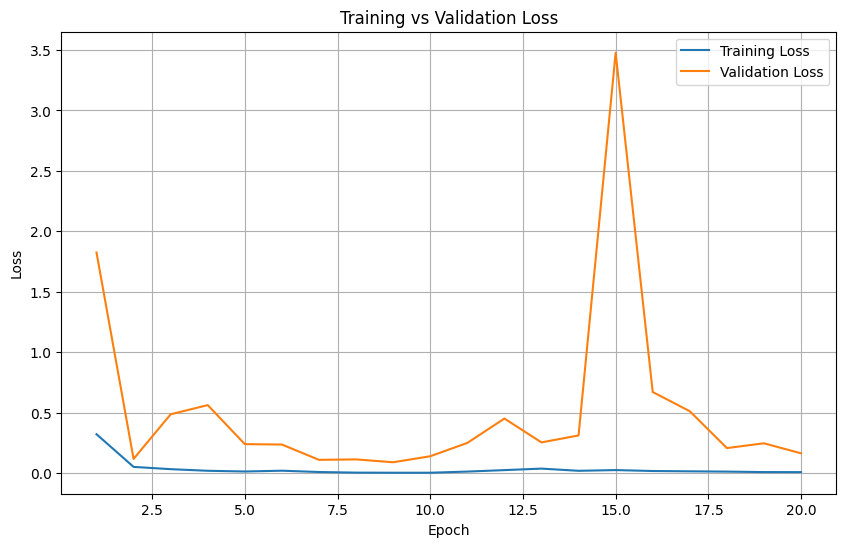

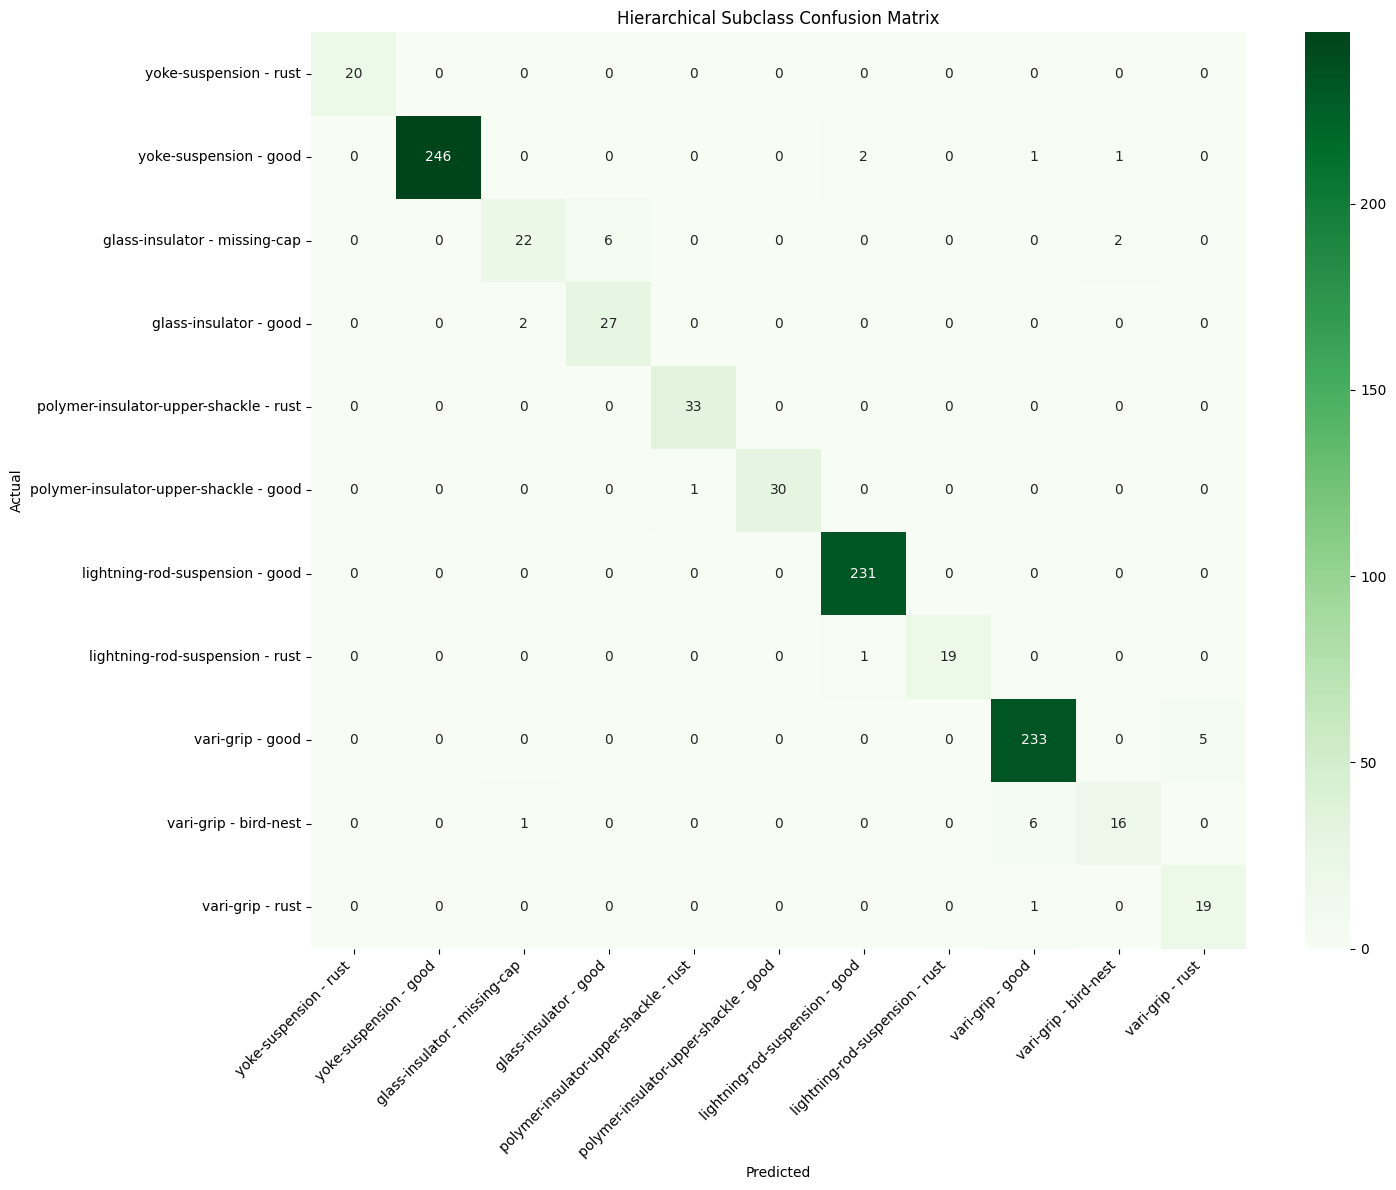


Classification Report:
                                        precision    recall  f1-score   support

                yoke-suspension - rust      1.000     1.000     1.000        20
                yoke-suspension - good      1.000     0.984     0.992       250
         glass-insulator - missing-cap      0.880     0.733     0.800        30
                glass-insulator - good      0.818     0.931     0.871        29
polymer-insulator-upper-shackle - rust      0.971     1.000     0.985        33
polymer-insulator-upper-shackle - good      1.000     0.968     0.984        31
       lightning-rod-suspension - good      0.987     1.000     0.994       231
       lightning-rod-suspension - rust      1.000     0.950     0.974        20
                      vari-grip - good      0.967     0.979     0.973       238
                 vari-grip - bird-nest      0.842     0.696     0.762        23
                      vari-grip - rust      0.792     0.950     0.864        20

              

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/insplad'
base_path = f'{root_path}/defect_supervised'
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import label_binarize
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image
import os
from sklearn.metrics import classification_report, confusion_matrix, brier_score_loss, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class InsPLADDataset(Dataset):
    def __init__(self, root_dir: str, split: str = 'train', transform=None, class_to_idx=None):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.samples = []

        if class_to_idx is None:
            # Build class mapping from all data
            self._build_class_mapping()
        else:
            self.hierarchical_class_to_idx = class_to_idx
            self.idx_to_hierarchical_class = {idx: class_name for class_name, idx in class_to_idx.items()}

        self._parse_directory()

    def _build_class_mapping(self):
        # Build class mapping from both train and val splits
        self.hierarchical_class_to_idx = {}
        self.idx_to_hierarchical_class = {}
        global_idx = 0

        # Iterate through main classes
        for main_class in os.listdir(self.root_dir):
            main_class_dir = os.path.join(self.root_dir, main_class)
            if not os.path.isdir(main_class_dir):
                continue

            # Iterate through splits
            for split in ['train', 'val']:
                split_dir = os.path.join(main_class_dir, split)
                if not os.path.exists(split_dir):
                    continue

                # Iterate through subclasses
                for subclass in os.listdir(split_dir):
                    subclass_dir = os.path.join(split_dir, subclass)
                    if not os.path.isdir(subclass_dir):
                        continue

                    # Create hierarchical class mapping
                    hierarchical_key = f"{main_class} - {subclass}"
                    if hierarchical_key not in self.hierarchical_class_to_idx:
                        self.hierarchical_class_to_idx[hierarchical_key] = global_idx
                        self.idx_to_hierarchical_class[global_idx] = hierarchical_key
                        global_idx += 1

    def _parse_directory(self):
        global_idx = 0

        # Iterate through main classes
        for main_class in os.listdir(self.root_dir):
            main_class_dir = os.path.join(self.root_dir, main_class)
            if not os.path.isdir(main_class_dir):
                continue

            # Get the split directory (train or val)
            split_dir = os.path.join(main_class_dir, self.split)
            if not os.path.exists(split_dir):
                print(f"Warning: {split_dir} does not exist")
                continue

            # Iterate through subclasses
            for subclass in os.listdir(split_dir):
                subclass_dir = os.path.join(split_dir, subclass)
                if not os.path.isdir(subclass_dir):
                    continue

                # Create hierarchical class mapping
                hierarchical_key = f"{main_class} - {subclass}"
                if hierarchical_key not in self.hierarchical_class_to_idx:
                    self.hierarchical_class_to_idx[hierarchical_key] = global_idx
                    self.idx_to_hierarchical_class[global_idx] = hierarchical_key
                    global_idx += 1

                # Collect image samples
                for img_name in os.listdir(subclass_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(subclass_dir, img_name)
                        self.samples.append({
                            'path': img_path,
                            'hierarchical_class': hierarchical_key,
                            'class_idx': self.hierarchical_class_to_idx[hierarchical_key]
                        })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample['path']).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, sample['class_idx']

    def get_class_distribution(self):
        """Print distribution of classes in the dataset"""
        class_counts = {}
        for sample in self.samples:
            class_name = sample['hierarchical_class']
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

        print(f"\nClass distribution in {self.split} set:")
        for class_name, count in sorted(class_counts.items()):
            print(f"{class_name}: {count} images")
        print(f"Total: {len(self.samples)} images")



# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def train_and_evaluate(base_path, num_epochs=10, batch_size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Build the global class mapping
    temp_dataset = InsPLADDataset(root_dir=base_path)
    class_to_idx = temp_dataset.hierarchical_class_to_idx

    # Create train and validation datasets with the shared class mapping
    train_dataset = InsPLADDataset(root_dir=base_path, split='train', transform=train_transform, class_to_idx=class_to_idx)
    val_dataset = InsPLADDataset(root_dir=base_path, split='val', transform=val_transform, class_to_idx=class_to_idx)

    # Print dataset statistics
    train_dataset.get_class_distribution()
    val_dataset.get_class_distribution()

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Initialize model
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, len(class_to_idx))
    model = model.to(device)

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    class_names = [train_dataset.idx_to_hierarchical_class[i] for i in range(len(train_dataset.hierarchical_class_to_idx))]

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict().copy()
            print("New best model saved!")
        print("-" * 50)

    # Load best model
    model.load_state_dict(best_model_state)

    # Final evaluation with Brier Score calculation
    model.eval()
    final_predictions = []
    final_labels = []
    final_predictions_prob = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            final_predictions_prob.extend(probs.cpu().numpy())
            final_predictions.extend(predicted.cpu().numpy())
            final_labels.extend(labels.cpu().numpy())

    final_labels = np.array(final_labels)
    final_predictions = np.array(final_predictions)
    final_predictions_prob = np.array(final_predictions_prob)

    # Calculate Brier Score
    num_classes = len(class_to_idx)
    final_labels_one_hot = label_binarize(final_labels, classes=range(num_classes))

    print("\nBrier Scores:")
    brier_scores = []
    for i in range(num_classes):
        true_labels_class_i = final_labels_one_hot[:, i]
        pred_probs_class_i = final_predictions_prob[:, i]
        brier = brier_score_loss(true_labels_class_i, pred_probs_class_i)
        brier_scores.append(brier)
        print(f"Class {class_names[i]}: {brier:.4f}")

        micro_auc = roc_auc_score(final_labels_one_hot, final_predictions_prob, average='micro')
    macro_auc = roc_auc_score(final_labels_one_hot, final_predictions_prob, average='macro')

    print("\nAUC Scores:")
    print(f"Micro-average AUC: {micro_auc:.4f}")
    print(f"Macro-average AUC: {macro_auc:.4f}")

    overall_brier_score = np.mean(np.sum((final_predictions_prob - final_labels_one_hot) ** 2, axis=1))
    print(f"Overall Brier Score: {overall_brier_score:.4f}")

    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Generate confusion matrix
    conf_matrix = confusion_matrix(final_labels, final_predictions)
    plt.figure(figsize=(15, 12))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Hierarchical Subclass Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(final_labels, final_predictions,
                              target_names=class_names, digits=3))

if __name__ == "__main__":
    train_and_evaluate(base_path, num_epochs=20, batch_size=256)